In [1]:
import os
import sys
import numpy as np
import scipy.ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt

try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.21.2
matplotlib version: 3.5.1
flopy version: 3.3.5


In [2]:
ws = os.path.join('temp')
if not os.path.exists(ws):
    os.makedirs(ws)

In [3]:
fn = os.path.join('..', 'uspb', 'results', 'USPB_capture_fraction_04_01.dat')
cf = np.loadtxt(fn)
print(cf.shape)

(110, 80)


In [4]:
cf2 = scipy.ndimage.zoom(cf, 4, order=0)
print(cf2.shape)

(440, 320)


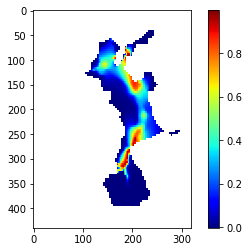

In [5]:
c = plt.imshow(cf2, cmap='jet')
plt.colorbar(c);

In [6]:
wsl = os.path.join('..', 'uspb', 'flopy')
ml = flopy.modflow.Modflow.load('DG.nam', model_ws=wsl, verbose=False)

In [7]:
nlay, nrow, ncol = ml.nlay, ml.dis.nrow, ml.dis.ncol
xmax, ymax = ncol * 250., nrow * 250.

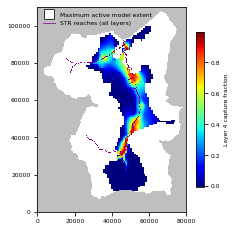

In [8]:
plt.rcParams.update({'font.size': 6})
fig = plt.figure(figsize=(3.25,4.47))
ax1 = plt.gca()
ax1.set_aspect('equal')
mm1 = flopy.plot.PlotMapView(model=ml, layer=4)
plt.xlim(0, xmax)
plt.ylim(0, ymax)
mm1.plot_inactive(color_noflow='0.75')
c = plt.imshow(cf2, cmap='jet', extent=[0, ncol*250., 0, nrow*250.])
cb = plt.colorbar(c, shrink=0.5)
cb.ax.set_ylabel('Layer 4 capture fraction')
mm1.plot_bc(ftype='STR', plotAll=True)
plt.plot([-10000], [-10000], marker='s', ms=10, lw=0.0, mec='0.2', mfc='white', 
         label='Maximum active model extent')
plt.plot([-10000,0], [-10000,0], color='purple', lw=0.75, label='STR reaches (all layers)')
leg = plt.legend(loc='upper left', numpoints=1, prop={'size':6})
leg.draw_frame(False)
plt.xticks([0, 20000, 40000, 60000, 80000])
plt.tight_layout()
plt.savefig(os.path.join(ws, 'capture_fraction_010y.png'), dpi=300);

Rerun the model after changing workspace and writing input files

In [9]:
ml.change_model_ws(ws)
ml.exe_name = 'mf2005dbl'
ml.write_input()
ml.run_model(silent=True)

(True, [])

In [10]:
hedObj = flopy.utils.HeadFile(os.path.join(ws, 'DG.hds'), precision='double')
h = hedObj.get_data(kstpkper=(0,0))
cbcObj = flopy.utils.CellBudgetFile(os.path.join(ws, 'DG.cbc'), precision='double')

frf = cbcObj.get_data(kstpkper=(0,0), text='FLOW RIGHT FACE')[0]
fff = cbcObj.get_data(kstpkper=(0,0), text='FLOW FRONT FACE')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf, fff, None), ml)

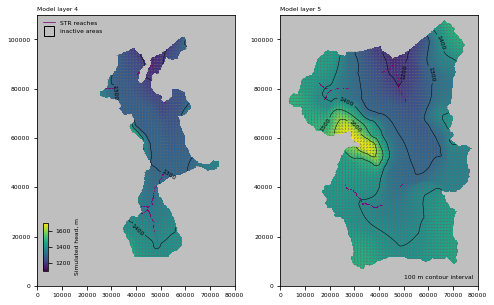

In [11]:
cnt = np.arange(1200, 1700, 100)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 4.47), constrained_layout=True)
ax1.set_xlim(0, xmax)
ax1.set_ylim(0, ymax)
ax2.set_xlim(0, xmax)
ax2.set_ylim(0, ymax)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

mm1 = flopy.plot.PlotMapView(model=ml, ax=ax1, layer=3)
h1 = mm1.plot_array(h, masked_values=[-888, -999], vmin=1100, vmax=1700)
mm1.plot_inactive(color_noflow='0.75')
mm1.plot_bc(ftype='STR')
q1 = mm1.plot_vector(qx, qy, istep=5, jstep=5, normalize=True, 
                     color='0.4', scale=70,
                     headwidth=3, headlength=3, headaxislength=3)
c1 = mm1.contour_array(h, masked_values=[-888, -999], colors='black', levels=cnt, 
                       linewidths=0.5)
ax1.clabel(c1, fmt='%.0f', inline_spacing=0.5)

mm2 = flopy.plot.PlotMapView(model=ml, ax=ax2, layer=4)
h2 = mm2.plot_array(h, masked_values=[-888, -999], vmin=1100, vmax=1700)
mm2.plot_inactive(color_noflow='0.75')
mm2.plot_bc(ftype='STR')
q2 = mm2.plot_vector(qx, qy, istep=5, jstep=5, normalize=True, 
                     color='0.4', scale=70,
                     headwidth=3, headlength=3, headaxislength=3)
c2 = mm2.contour_array(h, masked_values=[-888, -999], colors='black', levels=cnt, 
                       linewidths=0.5)
ax2.clabel(c2, fmt='%.0f', inline_spacing=0.5)

ax3 = f.add_axes([0.08, 0.125, 0.01, 0.15])
cb = plt.colorbar(h2, cax=ax3)
cb.ax.set_ylabel('Simulated head, m')

ax1.plot([-10000,0], [-10000,0], color='purple', lw=0.75, label='STR reaches')
ax1.plot([-10000], [-10000], marker='s', ms=10, lw=0.0, mec='black', mfc='None', 
         label='inactive areas')
leg = ax1.legend(loc='upper left', numpoints=1, prop={'size':6})
leg.draw_frame(False)

ax1.text(0.0, 1.01, 'Model layer 4', ha='left', va='bottom',
         transform=ax1.transAxes)
ax2.text(0.98, 0.02, '100 m contour interval', ha='right', va='bottom',
         transform=ax2.transAxes)
ax2.text(0.0, 1.01, 'Model layer 5', ha='left', va='bottom',
         transform=ax2.transAxes)

plt.savefig(os.path.join(ws, 'uspb_heads.png'), dpi=300);

In [12]:
fn = os.path.join('..', 'uspb', 'results', 'USPB_capture_fraction_04_10.dat')
cf = np.loadtxt(fn)
cf2 = scipy.ndimage.zoom(cf, 4, order=0)

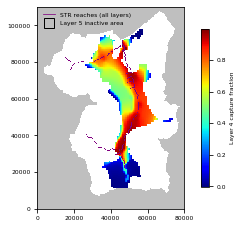

In [13]:
fig = plt.figure(figsize=(3.25,4.47), constrained_layout=True)
ax1 = plt.gca()
ax1.set_aspect('equal')
mm1 = flopy.plot.PlotMapView(model=ml, layer=4)
plt.xlim(0, xmax)
plt.ylim(0, ymax)
mm1.plot_inactive(color_noflow='0.75')
c = plt.imshow(cf2, cmap='jet', extent=[0, ncol*250., 0, nrow*250.])
cb = plt.colorbar(c, shrink=0.5)
cb.ax.set_ylabel('Layer 4 capture fraction')
mm1.plot_bc(ftype='STR', plotAll=True)
plt.plot([-10000,0], [-10000,0], color='purple', lw=0.75, label='STR reaches (all layers)')
plt.plot([-10000], [-10000], marker='s', ms=10, lw=0.0, mec='black', mfc='None', 
         label='Layer 5 inactive area')
leg = plt.legend(loc='upper left', numpoints=1, prop={'size':6})
leg.draw_frame(False)
plt.xticks([0, 20000, 40000, 60000, 80000])
plt.savefig(os.path.join(ws, 'capture_fraction_100y.png'), dpi=300);